Import libraries

In [26]:
 # Cell 1 — imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


%matplotlib inline


Load datasets

In [27]:
# Cell 2 — helper functions for loading and normalizing OHLCV files
from pathlib import Path
RAW = Path('data/raw')
PROCESSED = Path('data/processed')
PROCESSED.mkdir(parents=True, exist_ok=True)

def load_csv_guess(path):
    """Load CSV and try to detect a timestamp column. Returns DataFrame with datetime index."""
    df = pd.read_csv(path)
    # look for timestamp-like column names
    possible_ts = [c for c in df.columns if any(k in c.lower() for k in ['time','date','timestamp'])]
    if not possible_ts:
        # fallback: assume first column is timestamp
        ts = df.columns[0]
    else:
        ts = possible_ts[0]
    df[ts] = pd.to_datetime(df[ts], utc=True, errors='coerce')
    df = df.dropna(subset=[ts])
    df = df.set_index(ts).sort_index()
    return df

def unify_ohlcv(df):
    """Rename columns so we have open, high, low, close, volume."""
    cols = {c.lower(): c for c in df.columns}
    rename = {}
    for c in df.columns:
        low = c.lower()
        if 'open' in low or low == 'o':
            rename[c] = 'open'
        elif 'high' in low or low == 'h':
            rename[c] = 'high'
        elif 'low' in low or low == 'l':
            rename[c] = 'low'
        elif 'close' in low or 'adj_close' in low or low == 'c' or 'price' in low:
            rename[c] = 'close'
        elif 'volume' in low or 'vol' in low:
            rename[c] = 'volume'

    df = df.rename(columns=rename)

    # ensure required columns
    if 'close' not in df.columns:
        raise ValueError('No close column found after normalization.')
    for col in ['open', 'high', 'low']:
        if col not in df.columns:
            # fill with close if missing (conservative fallback)
            df[col] = df['close']
    if 'volume' not in df.columns:
        df['volume'] = 0.0

    return df[['open', 'high', 'low', 'close', 'volume']]

def resample_hourly(df):
    """Resample standardized OHLCV to 1H bars and forward-fill missing bars."""
    ohlc = df[['open', 'high', 'low', 'close', 'volume']].resample('1H').agg({
        'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'
    })
    ohlc = ohlc.ffill()
    return ohlc


Load a dataset CSV 

In [28]:
# Cell 3 — Load your selected file
from pathlib import Path

RAW = Path("data/raw")
raw_file = RAW / "btc_1h_data_2018_to_2025.csv"

print("Loading:", raw_file)

df_raw = load_csv_guess(raw_file)

print("Loaded! Shape:", df_raw.shape)
print(df_raw.head())


Loading: data\raw\btc_1h_data_2018_to_2025.csv
Loaded! Shape: (69334, 11)
                               Open      High       Low     Close      Volume  \
Open time                                                                       
2018-01-01 00:00:00+00:00  13715.65  13715.65  13400.01  13529.01  443.356199   
2018-01-01 01:00:00+00:00  13528.99  13595.89  13155.38  13203.06  383.697006   
2018-01-01 02:00:00+00:00  13203.00  13418.43  13200.00  13330.18  429.064572   
2018-01-01 03:00:00+00:00  13330.26  13611.27  13290.00  13410.03  420.087030   
2018-01-01 04:00:00+00:00  13434.98  13623.29  13322.15  13601.01  340.807329   

                                            Close time  Quote asset volume  \
Open time                                                                    
2018-01-01 00:00:00+00:00  2018-01-01 00:59:59.999000         5.993910e+06   
2018-01-01 01:00:00+00:00  2018-01-01 01:59:59.999000         5.154522e+06   
2018-01-01 02:00:00+00:00  2018-01-01 02:59:59

In [29]:
# Check exact time range of the dataset

start_time = ohlc_clean.index.min()
end_time = ohlc_clean.index.max()
total_rows = len(ohlc_clean)

print("===== DATASET TIME RANGE =====")
print(f"Start : {start_time}")
print(f"End   : {end_time}")
print(f"Total Hours: {total_rows:,} (≈ {total_rows/24:.2f} days ≈ {total_rows/24/365:.2f} years)")


===== DATASET TIME RANGE =====
Start : 2018-01-01 00:00:00+00:00
End   : 2025-12-03 21:00:00+00:00
Total Hours: 69,332 (≈ 2888.83 days ≈ 7.91 years)


Normalize columns and resample

In [30]:
print(df_raw.index)
print(df_raw.head())


DatetimeIndex(['2018-01-01 00:00:00+00:00', '2018-01-01 01:00:00+00:00',
               '2018-01-01 02:00:00+00:00', '2018-01-01 03:00:00+00:00',
               '2018-01-01 04:00:00+00:00', '2018-01-01 05:00:00+00:00',
               '2018-01-01 06:00:00+00:00', '2018-01-01 07:00:00+00:00',
               '2018-01-01 08:00:00+00:00', '2018-01-01 09:00:00+00:00',
               ...
               '2025-12-03 12:00:00+00:00', '2025-12-03 13:00:00+00:00',
               '2025-12-03 14:00:00+00:00', '2025-12-03 15:00:00+00:00',
               '2025-12-03 16:00:00+00:00', '2025-12-03 17:00:00+00:00',
               '2025-12-03 18:00:00+00:00', '2025-12-03 19:00:00+00:00',
               '2025-12-03 20:00:00+00:00', '2025-12-03 21:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Open time', length=69334, freq=None)
                               Open      High       Low     Close      Volume  \
Open time                                                                       
20

In [31]:
# Cell 4 — Unify columns for Binance-style CSV (your dataset)

def unify_ohlcv(df):
    df = df.copy()
    df = df.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Volume': 'volume'
    })
    
    # Keep only needed columns
    df = df[['open', 'high', 'low', 'close', 'volume']]
    return df

# Since your data is already in 1H resolution, resample is not needed
ohlc = unify_ohlcv(df_raw)
print("Unified OHLCV:")
ohlc.head()


Unified OHLCV:


,open,high,low,close,volume
Open time,,,,,
2018-01-01 00:00:00+00:00,13715.65,13715.65,13400.01,13529.01,443.356199
2018-01-01 01:00:00+00:00,13528.99,13595.89,13155.38,13203.06,383.697006
2018-01-01 02:00:00+00:00,13203.00,13418.43,13200.00,13330.18,429.064572
2018-01-01 03:00:00+00:00,13330.26,13611.27,13290.00,13410.03,420.087030
2018-01-01 04:00:00+00:00,13434.98,13623.29,13322.15,13601.01,340.807329


In [32]:
# Cell 5 — Clean & Validate OHLCV

def clean_ohlcv(df):
    df = df.copy()

    # Ensure sorted by timestamp
    df = df.sort_index()

    # Remove duplicates (rare)
    df = df[~df.index.duplicated(keep='first')]

    # Check for missing values
    print("Missing values per column:")
    print(df.isna().sum())

    # Forward-fill any small gaps (usually none)
    df = df.ffill()

    return df

ohlc_clean = clean_ohlcv(ohlc)
print("Shape after cleaning:", ohlc_clean.shape)
ohlc_clean.head()


Missing values per column:
open      0
high      0
low       0
close     0
volume    0
dtype: int64
Shape after cleaning: (69332, 5)


,open,high,low,close,volume
Open time,,,,,
2018-01-01 00:00:00+00:00,13715.65,13715.65,13400.01,13529.01,443.356199
2018-01-01 01:00:00+00:00,13528.99,13595.89,13155.38,13203.06,383.697006
2018-01-01 02:00:00+00:00,13203.00,13418.43,13200.00,13330.18,429.064572
2018-01-01 03:00:00+00:00,13330.26,13611.27,13290.00,13410.03,420.087030
2018-01-01 04:00:00+00:00,13434.98,13623.29,13322.15,13601.01,340.807329


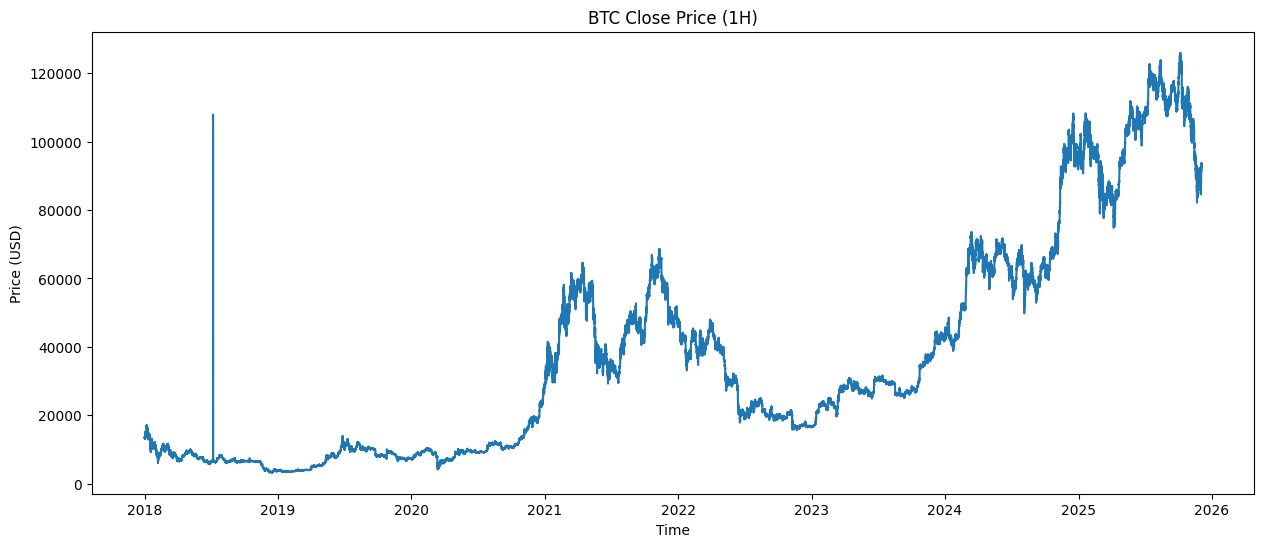

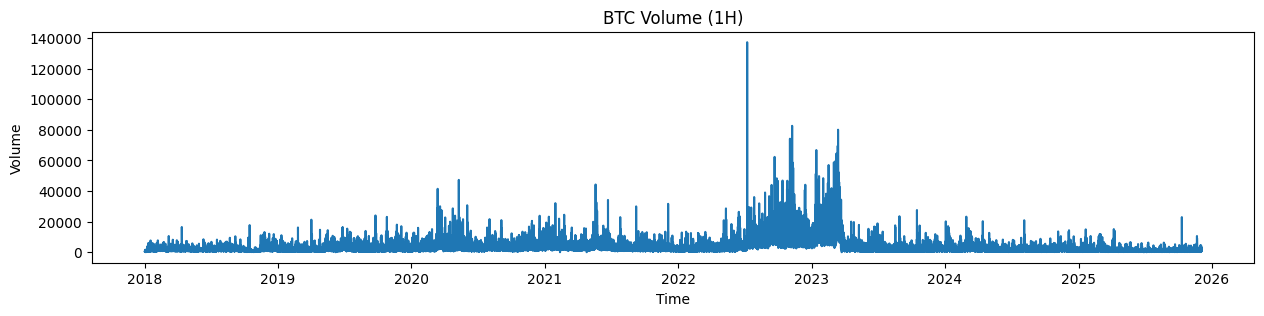

In [33]:
# Cell 6 — Visualize OHLC Close Price + Volume

plt.figure(figsize=(15,6))
plt.plot(ohlc_clean.index, ohlc_clean['close'])
plt.title("BTC Close Price (1H)")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.show()

plt.figure(figsize=(15,3))
plt.plot(ohlc_clean.index, ohlc_clean['volume'])
plt.title("BTC Volume (1H)")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.show()


In [34]:
# Cell — Save cleaned OHLC data for Notebook 02
from pathlib import Path

OUT = Path("data/processed")
OUT.mkdir(parents=True, exist_ok=True)

save_path = OUT / "ohlc_clean.csv"
ohlc_clean.to_csv(save_path)

print("Saved cleaned OHLCV to:", save_path)


Saved cleaned OHLCV to: data\processed\ohlc_clean.csv
